In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import pickle
import xgboost as xgb
import seaborn as sns

<a id='sampling'></a>
## Compiling Sample Dataset

In [3]:
df1 = pd.read_csv('Jan_01_10_2018.csv', sep = ",")
df2 = pd.read_csv('Jan_11_20_2018.csv', sep = ",")
df3 = pd.read_csv('Jan_21_31_2018.csv', sep = ",")
df4 = pd.read_csv('Dec_21_31_2018.csv', sep = ",")
df5 = pd.read_csv('Jan_01_07_2019.csv', sep = ",")
df6 = pd.read_csv('Jan_08_15_2019.csv', sep = ",")
df7 = pd.read_csv('Jan_16_22_2019.csv', sep = ",")
df8 = pd.read_csv('Jan_23_31_2019.csv', sep = ",")
df9 = pd.read_csv('Dec_21_31_2019.csv', sep = ",")

/home/vishal/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df = pd.concat([df1, df2,df3,df5,df6,df7,df8,df9])

In [5]:
df = df.sort_values('fl_date', ascending = True)

In [6]:
df = df.drop_duplicates()

In [7]:
df['month'] = pd.DatetimeIndex(df.fl_date).month
df['year'] = pd.DatetimeIndex(df.fl_date).year
df['day'] = pd.DatetimeIndex(df.fl_date).day
df['dayofweek'] = pd.DatetimeIndex(df.fl_date).weekday
df['dayofyear'] = pd.DatetimeIndex(df.fl_date).dayofyear

In [8]:
df['month']=df['month'].apply(lambda x: '{0:0>2}'.format(x))
df['day']=df['day'].apply(lambda x: '{0:0>2}'.format(x))
df['dayofyear'] = df['dayofyear'].apply(lambda x: '{0:0>3}'.format(x))
df['crs_dep_time'] = df['crs_dep_time'].apply(lambda x: '{0:0>4}'.format(x))
df['crs_arr_time'] = df['crs_arr_time'].apply(lambda x: '{0:0>4}'.format(x))
df['dep_time'] = df['dep_time'].apply(lambda x: '{0:0>4}'.format(x))
df['arr_time'] = df['arr_time'].apply(lambda x: '{0:0>4}'.format(x))
df['date'] = (df.year.astype(str) + df.month.astype(str) + df.day.astype(str)).astype(int)

In [9]:
#Creating uid to match with average delay data
df['op_carrier_fl_num']=df['op_carrier_fl_num'].apply(lambda x: '{0:0>4}'.format(x))
df['uid'] = df.origin_airport_id.astype(str) + df.op_carrier_fl_num.astype(str) + df.dest_airport_id.astype(str)

In [10]:
#Creating uid2 to match with passengers data
df['uid2'] = df.origin_airport_id.astype(str) + df.year.astype(str) + df.month.astype(str)+ df.op_unique_carrier.astype(str) + df.dest_airport_id.astype(str)

In [11]:
df = df.reset_index()

In [11]:
#Save the file. Saving the file remove all the leading zeroes. Need to reapply leading zeros if uploading csv.
df.to_csv('pruned_data.csv', index = False)
df.columns

Index(['index', 'fl_date', 'mkt_unique_carrier', 'branded_code_share',
       'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name', 'month', 'year', 'day', 'dayofweek',
       'dayofyear', 'date', 'uid', 'uid2'],
      dtype='object')

In [13]:
df_model = df[['uid', 'uid2','date', 'dayofweek', 'dayofyear','op_unique_carrier','op_carrier_fl_num', 'origin_airport_id', 'origin',
       'dest_airport_id', 'dest','crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time','total_add_gtime',
       'longest_add_gtime']]

<a id='featuring'></a>
#### Feature Engineering & Selection

In [15]:
#Importing csv with computation of average delay times
avg_delays = pd.read_csv('../SQL/average_delays2.csv')
avg_delays['op_carrier_fl_num']=avg_delays['op_carrier_fl_num'].apply(lambda x: '{0:0>4}'.format(x))

In [16]:
#Combining airport_id + op_carrier_fl_num to form one uid to merge with flights data
avg_delays['uid'] = avg_delays.oid.astype(str) + avg_delays.op_carrier_fl_num.astype(str) + avg_delays.did.astype(str)

In [17]:
#Importing csv with passengers data
passengers = pd.read_csv('passengers_data.csv')

In [18]:
passengers = passengers.rename(columns = {'sum':'payload', 'sum.1':'seats','sum.2':'passengers'})

In [20]:
#Selecting passengers data only for 2018, 2019 and for the carriers in the primary data
carriers = ['WN','AA','OO','DL','UA','MQ','YX','OH','B6','9E',
'YV','AS','EV','NK','PT','F9','QX','ZW','AX','G7','G4','CP','HA','C5','VX','EM','KS','9K']
pass_small = passengers[passengers.unique_carrier.isin(carriers)][passengers.year.isin([2018,2019])]

/tmp/ipykernel_4461/1604502537.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pass_small = passengers[passengers.unique_carrier.isin(carriers)][passengers.year.isin([2018,2019])]


In [21]:
#Converting monthly payload, seats and passenger figures to daily figures
pass_small['payload'][pass_small.month.isin([1,3,5,7,8,10,12])] = pass_small['payload'][pass_small.month.isin([1,3,5,7,8,10,12])].div(31).round(0)
pass_small['seats'][pass_small.month.isin([1,3,5,7,8,10,12])] = pass_small['seats'][pass_small.month.isin([1,3,5,7,8,10,12])].div(31).round(0)
pass_small['passengers'][pass_small.month.isin([1,3,5,7,8,10,12])] = pass_small['passengers'][pass_small.month.isin([1,3,5,7,8,10,12])].div(31).round(0)
pass_small['payload'][pass_small.month.isin([4,6,9,11])] = pass_small['payload'][pass_small.month.isin([4,6,9,11])].div(30).round(0)
pass_small['seats'][pass_small.month.isin([4,6,9,11])] = pass_small['seats'][pass_small.month.isin([4,6,9,11])].div(30).round(0)
pass_small['passengers'][pass_small.month.isin([4,6,9,11])] = pass_small['passengers'][pass_small.month.isin([4,6,9,11])].div(30).round(0)
pass_small['payload'][pass_small.month.isin([2])] = pass_small['payload'][pass_small.month.isin([2])].div(28).round(0)
pass_small['seats'][pass_small.month.isin([2])] = pass_small['seats'][pass_small.month.isin([2])].div(28).round(0)
pass_small['passengers'][pass_small.month.isin([2])] = pass_small['passengers'][pass_small.month.isin([2])].div(28).round(0)
pass_small = pass_small.reset_index()

/tmp/ipykernel_4461/4064639945.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_small['payload'][pass_small.month.isin([4,6,9,11])] = pass_small['payload'][pass_small.month.isin([4,6,9,11])].div(30).round(0)
/tmp/ipykernel_4461/4064639945.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_small['seats'][pass_small.month.isin([4,6,9,11])] = pass_small['seats'][pass_small.month.isin([4,6,9,11])].div(30).round(0)
/tmp/ipykernel_4461/4064639945.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [22]:
pass_small = pass_small.drop(columns=['index','origin','dest'])

In [23]:
#Creating Unique ID2 to match with flights data
pass_small['month']=pass_small['month'].apply(lambda x: '{0:0>2}'.format(x))
pass_small['uid2'] = pass_small.origin_airport_id.astype(str) + pass_small.year.astype(str) + pass_small.month.astype(str)+ pass_small.unique_carrier.astype(str) + pass_small.dest_airport_id.astype(str)

In [24]:
#Merging average delays to model dataset
df_model = df_model.merge(avg_delays, how='left', on='uid')

In [25]:
#Merging passengers data to model dataset
df_model = df_model.merge(pass_small, how='left', on='uid2')

In [23]:
#Save the file as csv
df_model.to_csv('raw_model_data1.csv',index=False)
#df_model = pd.read_csv('raw_model_data1.csv')

#### Replacing categorical variables & converting to numeric

In [26]:
df_model.op_unique_carrier = df_model.op_unique_carrier.replace(['WN','AA','OO','DL','UA','MQ','YX','OH','B6','9E',
'YV','AS','EV','NK','PT','F9','QX','ZW','AX','G7','G4','CP','HA','C5','VX','EM','KS','9K'], list((range(28))))

In [27]:
df_model.cancellation_code = df_model.cancellation_code.replace(['B', 'A', 'C', 'D', 'X'],[1,2,3,4,5])
df_model.cancellation_code = df_model.cancellation_code.fillna(0)

In [28]:
# Removing reduntant/repeating columns
df_model = df_model.drop(['uid', 'uid2','origin','dest','oid', 'did','op_carrier_fl_num_y','year', 'month','unique_carrier',
       'origin_airport_id_y', 'dest_airport_id_y'], axis =1)

In [29]:
df_model = df_model.fillna(0)

In [30]:
# Save refined data to be used for modelling
df_model.to_csv('refined_data.csv', index=False)
#df_model = pd.read_csv('refined_data.csv')

In [77]:
X = df_model[['date', 'dayofweek', 'dayofyear', 'op_unique_carrier',
       'op_carrier_fl_num_x', 'origin_airport_id_x', 'dest_airport_id_x',
       'crs_dep_time','crs_arr_time', 'crs_elapsed_time','distance',
       'arr_del_avg', 'dep_del_avg', 'car_del_avg', 'wth_del_avg',
       'nas_del_avg', 'sec_del_avg', 'acft_del_avg', 'taxi_in_avg',
       'taxi_out_avg', 'elp_time_diff_avg', 'payload', 'seats', 'passengers']]
y = df_model['arr_delay']

In [33]:
X.shape

(1476341, 24)

#### Eliminate Low Variance & High Correlation

In [34]:
# Defining functions to remove low variance and high correlation
#from sklearn.feature_selection import VarianceThreshold

def eliminateLowVariance(x, df):
    """
    x should be between 0 and 1
    """
    vt = VarianceThreshold(x)
    vt.fit(df)
    return df.loc[:, vt.variances_ > x]

def eliminateCorrFeatures(coef_, df):
    """
    coef_ should be between 0 and 1
    """
    # step 1
    df_corr = df.corr().abs()

    # step 2
    indices = np.where(df_corr > coef_) 
    indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]

    # step 3
    for idx in indices: #each pair
        try:
            df.drop(idx[1], axis = 1, inplace=True)
        except KeyError:
            pass
    return df

In [35]:
X = eliminateLowVariance(0.2, X)
X.shape

(1476341, 24)

<AxesSubplot:>

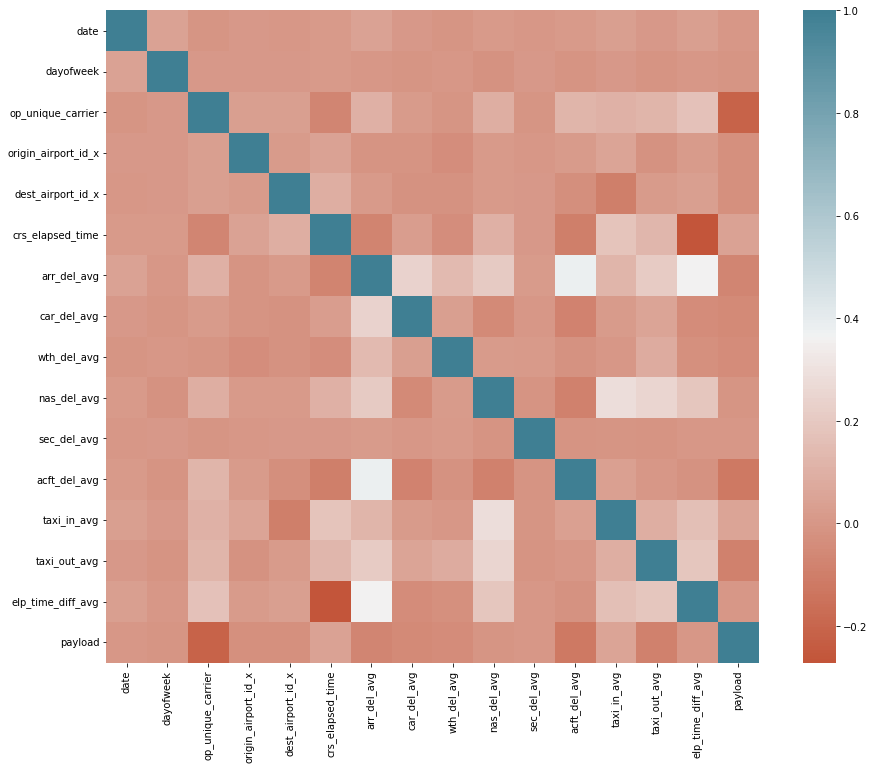

In [76]:
# Visualizing Correlation matrix
#import seaborn as sns
corrmat = X.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=1, square=True,cmap=sns.diverging_palette(20,220,n=200))      # "RdYlGn_r")

In [103]:
X = eliminateCorrFeatures(0.85, X)
X.shape

/home/vishal/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1476341, 20)

#### <a id='trials'></a>
#### Modeling Trials after scaling and splitting

In [104]:
#Scaling the input dataset
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [105]:
# Train_test_split
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.30, random_state=100)

In [106]:
#from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [107]:
y_lr = lr.predict(X_test)

In [108]:
# creating ridge regression
rr = Ridge(alpha=0.1)
rr.fit(X_train,y_train)

Ridge(alpha=0.1)

In [109]:
y_rr = rr.predict(X_test)

In [110]:
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_absolute_error
R2_lr = r2_score(y_test, y_lr)
R2_rr = r2_score(y_test, y_rr)
MAE_lr = mean_absolute_error(y_test, y_lr)
MAE_rr = mean_absolute_error(y_test, y_rr)
print (f'RSquared_Linear:  {R2_lr}')
print (f'RSquared_Ridge: {R2_rr}')
print (f'MAE_Linear:  {MAE_lr}')
print (f'MAE_Ridge: {MAE_rr}')

RSquared_Linear:  0.07323836370175063
RSquared_Ridge: 0.07323836481920865
MAE_Linear:  23.31564260546545
MAE_Ridge: 23.315642662551387


<a id='PCA'></a>
#### Using PCA to check if dimensionality can be reduced

In [42]:
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.impute import SimpleImputer

In [111]:
# PCA with number of componenets equal to number of features
pca = PCA(n_components=len(X.columns), random_state=42)
pca.fit(StandardScaler()
        .fit_transform(SimpleImputer(strategy="median")
                       .fit_transform(X)))

PCA(n_components=20, random_state=42)

In [112]:
# creating cumulative explained variance
print(pca.explained_variance_ratio_)
print("")
print(np.cumsum(pca.explained_variance_ratio_))

[0.11029625 0.09789315 0.07963892 0.072492   0.06104197 0.05883633
 0.05387744 0.05281409 0.05028184 0.04935457 0.0475814  0.04378802
 0.04073904 0.03857894 0.03506029 0.03137652 0.02808434 0.02043675
 0.01451599 0.01331215]

[0.11029625 0.2081894  0.28782832 0.36032032 0.42136228 0.48019862
 0.53407606 0.58689014 0.63717199 0.68652656 0.73410796 0.77789598
 0.81863502 0.85721397 0.89227426 0.92365078 0.95173512 0.97217187
 0.98668785 1.        ]


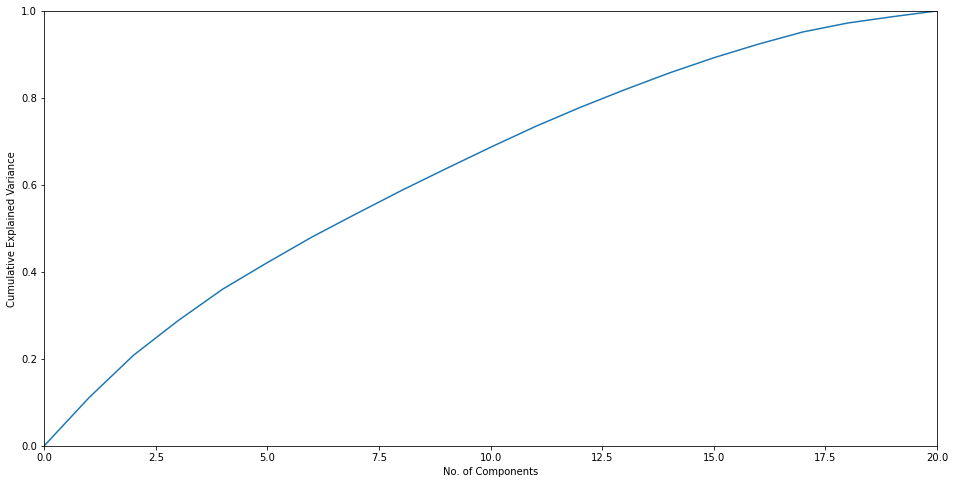

In [114]:
# plotting
#import matplotlib.pyplot as plt
#%matplotlib inline

x_pca = range(len(pca.explained_variance_ratio_)+1)
y_pca = [0]+ list(np.cumsum(pca.explained_variance_ratio_))
comps = 20

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
plt.plot(x_pca, y_pca)
plt.xlim(0,comps)
plt.ylim(0,1)
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [51]:
# Choosing 13 components as they explain 80% of variance
pca = PCA(n_components=13, random_state=42)
sc = StandardScaler()
si = SimpleImputer(strategy="median")
si.fit(X)
sc.fit(si.transform(X))
# fitting the PCA
pca.fit(sc.transform(si.transform(X)))
# projection of the data into the 4 axes of the trained PCA
pca_data = pca.transform(sc.transform(si.transform(X)))

In [52]:
pca_df = pd.DataFrame(pca_data, columns = ["pca_1","pca_2","pca_3","pca_4","pca_5","pca_6","pca_7","pca_8"
                                           ,"pca_9","pca_10","pca_11","pca_12","pca_13"])

In [53]:
# Train_test_split
pca_train, pca_test, ypca_train, ypca_test = train_test_split(pca_df, y, test_size=0.30, random_state=100)

In [54]:
# Using Linear Regression
lr = LinearRegression()
lr.fit(pca_train,ypca_train)

LinearRegression()

In [58]:
ypca_lr = lr.predict(pca_test)

In [55]:
#Using ridge regression
rr = Ridge(alpha=0.05)
rr.fit(pca_train,ypca_train)

Ridge(alpha=0.05)

In [56]:
ypca_rr = rr.predict(pca_test)

In [59]:
R2pca_lr = r2_score(ypca_test, ypca_lr)
R2pca_rr = r2_score(ypca_test, ypca_rr)
MAEpca_lr = mean_absolute_error(ypca_test, ypca_lr)
MAEpca_rr = mean_absolute_error(ypca_test, ypca_rr)
print (f'RSquared_Linear:  {R2pca_lr}')
print (f'RSquared_Ridge: {R2pca_rr}')
print (f'MAE_Linear:  {MAEpca_lr}')
print (f'MAE_Ridge: {MAEpca_rr}')

RSquared_Linear:  0.06345558772616089
RSquared_Ridge: 0.06345558774407267
MAE_Linear:  24.113283549147766
MAE_Ridge: 24.11328349873362


#### Reducing components using PCA has reduced the score. Hence, not taking PCA components into consideration.

#### Trying Polynomial Features

In [62]:
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.pipeline import make_pipeline

In [60]:
degree=2
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [61]:
ypoly = polyreg.predict(X_test)

In [62]:
R2poly = r2_score(y_test, ypoly)
MAEpoly = mean_absolute_error(y_test, ypoly)
print (f'RSquared_Linear:  {R2poly}')
print (f'MAE_Linear:  {MAEpoly}')

RSquared_Linear:  0.0796153555412088
MAE_Linear:  23.244152552954393


#### Random Forest Regressor

In [63]:
#from sklearn.ensemble import RandomForestRegressor
#Create a Regressor
rf_reg=RandomForestRegressor(max_depth = 5)

#Train the model using the training
rf_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=5)

In [64]:
y_rf=rf_reg.predict(X_test)

In [65]:
R2rf = r2_score(y_test, y_rf)
MAErf = mean_absolute_error(y_test, y_rf)
print (f'RSquared_Linear:  {R2rf}')
print (f'MAE_Linear:  {MAErf}')

RSquared_Linear:  0.07917643681529807
MAE_Linear:  23.13255238640249


#### XGB Boost

In [69]:
#import xgboost as xgb

In [115]:
# Instantiate XGB Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 5, alpha = 0.01, n_estimators = 1000)

In [116]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0.00999999978, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [117]:
y_xg = xg_reg.predict(X_test)

In [118]:
R2xg = r2_score(y_test, y_xg)
MAExg = mean_absolute_error(y_test, y_xg)
print (f'RSquared_Linear:  {R2xg}')
print (f'MAE_Linear:  {MAExg}')

RSquared_Linear:  0.10783209067984934
MAE_Linear:  22.456878854388147


In [119]:
#Calculating the RMSE:
#from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_xg))
print("RMSE: %f" % (rmse))

RMSE: 48.176837


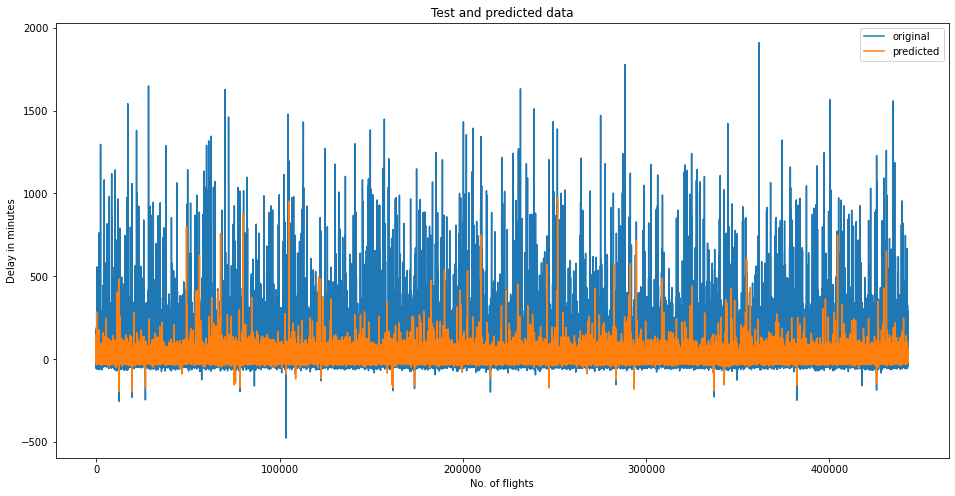

In [121]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(16,8))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_xg, label="predicted")

plt.title("Test and predicted data")
plt.xlabel('No. of flights')
plt.ylabel('Delay in minutes')

plt.legend()
plt.show()

<a id='selection'></a>
#### Comparing & Selecting the model

In [122]:
comparative = pd.DataFrame(data = {'Model': ['Linear Regression','Ridge Regression', 'Linear_withPCA', 'Ridge_withPCA', 'Polynomial Features', 'Random Forrest Regressor', 'XGB Regressor'],
                           'R2 Score': [ R2_lr, R2_rr, R2pca_lr, R2pca_rr, R2poly, R2rf, R2xg],
                           'MAE': [ MAE_lr, MAE_rr, MAEpca_lr, MAEpca_rr, MAEpoly, MAErf, MAExg]})

In [124]:
comparative.to_csv('Comparison.csv')
comparative

,Model,R2 Score,MAE
0,Linear Regression,0.073238,23.315643
1,Ridge Regression,0.073238,23.315643
2,Linear_withPCA,0.063456,24.113284
3,Ridge_withPCA,0.063456,24.113283
4,Polynomial Features,0.079615,23.244153
5,Random Forrest Regressor,0.079176,23.132552
6,XGB Regressor,0.107832,22.456879


<a id='tuning'></a>
#### Hyperparameter Tuning

In [ ]:
#from sklearn.model_selection import GridSearchCV

In [78]:
model = xgb.XGBRegressor()
parameters = [{'max_depth': [4,5], 'n_estimators':[100, 500, 1000],
               'learning_rate' : [0.05,0.1], 'alpha': [0.1,0.01,0.001]}]

In [81]:
# Create an object with the model and parameter candidates
reg = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

In [ ]:
# Train the classifier on data1's feature and target data
results = reg.fit(X_train, y_train)

In [ ]:
# View the score
print('Best score for data1:', results.best_score_)
# View the best parameters for the model found using grid search
print('Best parameters: ',results.best_params_) 

In [ ]:
# Apply the best params to the model
results.score(X_test, y_test)

In [115]:
# Instantiate XGB Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 5, alpha = 0.01, n_estimators = 1000)

In [ ]:
xg_reg.fit(X_train,y_train)

In [125]:
#Save the model best model to disk after fitting
#import pickle
filename = ('mid_termXGB.sav')
pickle.dump(xg_reg,open(filename,'wb'))

In [ ]:
#To retrieve model from disk
#loaded_model = pickle.load(open(filename,'rb'))